In [4]:
using PyPlot, SparseArrays
import Delaunator as D

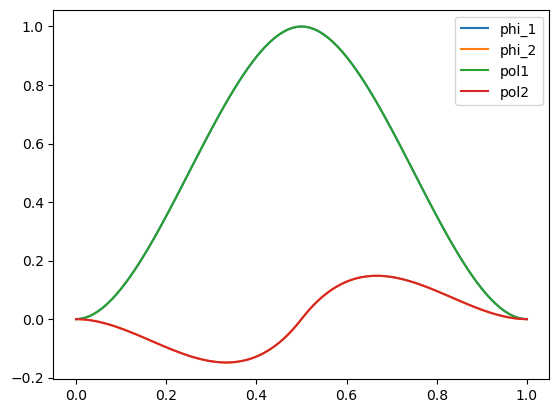

In [5]:
H0(η) = 2*η^3 - 3η^2 + 1
H1(η) = 3*η^2 - 2*η^3
H0_tilde(η) = η^3 - 2*η^2 + η
H1_tilde(η) = η^3 - η^2

function phi1(x)
    if x < 1/2
        return H1(2x)
    else
        return H0(2x-1)
    end
end
function phi2(x)
    if x < 1/2
        return H1_tilde(2x)
    else
        return H0_tilde(2x-1)
    end
end
function pol1(x)
    if x < 1/2
        return 12x^2-16x^3
    else
        return 16x^3-36x^2+24x-4
    end
end
function pol2(x)
    if x < 1/2
        return 8x^3-4x^2
    else
        return 8x^3-20x^2+16x-4
    end
end



x = (0:100)/100
fig, ax = subplots()
ax.plot(x, phi1.(x),label="phi_1")
ax.plot(x, phi2.(x),label="phi_2")
ax.plot(x, pol1.(x),label="pol1")
ax.plot(x, pol2.(x),label="pol2")
legend()
display(fig)

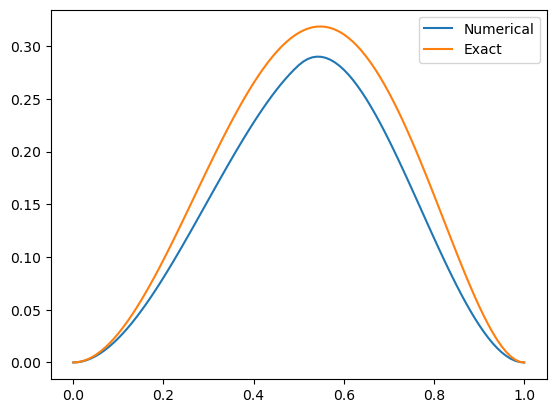

In [6]:
A = [224.0 -16.0; -16.0 64.0]
f = [60.0; 8.0]

u_h = A\f

u_num(x) = u_h[1]*phi1.(x) + u_h[2]*phi2.(x)
u_exact(x) = 4*x^5 - 5*x^4 - 2*x^3 + 3*x^2

x = (0:100)/100
fig, ax = subplots()
ax.plot(x, u_num(x),label="Numerical")
ax.plot(x, u_exact.(x),label="Exact")
legend()
display(fig)

2-element Vector{Float64}:
 0.0022727272727272726
 0.0005681818181818182

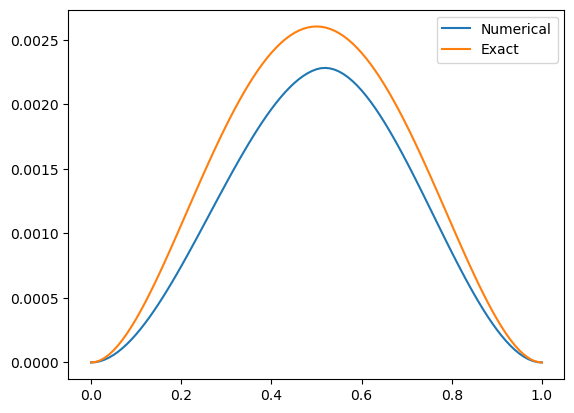

In [7]:
A = [224.0 -16.0; -16.0 64.0]
f = [0.5; 0]
u_h = A\f
display(u_h)
u_num(x) = u_h[1]*phi1.(x) + u_h[2]*phi2.(x)
u_exact(x) = (1/24)*x^4 - (1/12)*x^3 + (1/24)*x^2

x = (0:100)/100
fig, ax = subplots()
ax.plot(x, u_num(x),label="Numerical")
ax.plot(x, u_exact.(x),label="Exact")
legend()
display(fig)

In [8]:
# Functions obtained from the webpage
"""
    t = delaunay(p)

Delaunay triangulation `t` of N x 2 node array `p`.
"""
delaunay(p) = collect(reinterpret(reshape, Int32, 
        D.triangulate(D.PointsFromMatrix(p')).triangles)')

"""
inside = inpolygon(p, pv)

Determine if each point in the N x 2 node array `p` is inside the polygon
described by the NE x 2 node array `pv`.
"""
function inpolygon(p, pv)
    if ndims(p) == 2 && size(p,2) == 2
        return [ inpolygon(p[ip,:], pv) for ip = 1:size(p,1) ]
    end
    cn = 0
    for i = 1:size(pv,1) - 1
        if pv[i,2] <= p[2] && pv[i+1,2] > p[2] ||
            pv[i,2] > p[2] && pv[i+1,2] <= p[2]
            vt = (p[2] - pv[i,2]) / (pv[i+1,2] - pv[i,2])
            if p[1] < pv[i,1] + vt * (pv[i+1,1] - pv[i,1])
                cn += 1
            end
        end
    end
    return cn % 2 == 1
end
"""
    edges, boundary_indices, emap = all_edges(t)

Find all unique edges in the triangulation `t` (ne x 2 array)
Second output is indices to the boundary edges.
Third output emap (nt x 3 array) is a mapping from local triangle edges
to the global edge list, i.e., emap[it,k] is the global edge number
for local edge k (1,2,3) in triangle it.
"""
function all_edges(t)
    etag = vcat(t[:,[1,2]], t[:,[2,3]], t[:,[3,1]])
    etag = hcat(sort(etag, dims=2), 1:3*size(t,1))
    etag = sortslices(etag, dims=1)
    dup = all(etag[2:end,1:2] - etag[1:end-1,1:2] .== 0, dims=2)[:]
    keep = .![false;dup]
    edges = etag[keep,1:2]
    emap = cumsum(keep)
    invpermute!(emap, etag[:,3])
    emap = reshape(emap,:,3)
    dup = [dup;false]
    dup = dup[keep]
    bndix = findall(.!dup)
    return edges, bndix, emap
end
"""
    tplot(p, t, u=nothing)

If `u` == nothing: Plot triangular mesh with nodes `p` and triangles `t`.
If `u` == solution vector: Plot filled contour color plot of solution `u`.
"""
function tplot(p, t, u=nothing)
    clf()
    axis("equal")
    if u == nothing
        tripcolor(p[:,1], p[:,2], Array(t .- 1), 0*t[:,1],
                  cmap="Set3", edgecolors="k", linewidth=1)
    else
        tricontourf(p[:,1], p[:,2], Array(t .- 1), u[:], 20)
    end
    draw()
end
"""
    e = boundary_nodes(t)

Find all boundary nodes in the triangulation `t`.
"""
function boundary_nodes(t)
    edges, boundary_indices, _ = all_edges(t)
    return unique(edges[boundary_indices,:][:])
end

boundary_nodes

In [9]:
# Helper functions

function area(p, triangle)
    points = [p[triangle[1],:] p[triangle[2],:] p[triangle[3],:]]
    x, y = points[1,:], points[2,:]
    return 1/2 * abs(x[1]*(y[2]-y[3]) + x[2]*(y[3]-y[1]) + x[3]*(y[1]-y[2]))
end

function findlargest(p, t)
    maxarea = 0
    maxindex = 0
    for i = 1:size(t, 1)
        if area(p, t[i, :]) > maxarea
            maxarea = area(p, t[i, :])
            maxindex = i
        end
    end
    return maxarea, maxindex
end

function circumcenter(A, B, C)
    # Formula obtained from https://en.wikipedia.org/wiki/Circumcircle
    B = B - A
    C = C - A
    D = 2 * (B[1]*C[2] - B[2]*C[1])
    Ux = 1 / D * (C[2] * (B[1]^2 + B[2]^2) - B[2] * (C[1]^2 + C[2]^2))
    Uy = 1 / D * (B[1] * (C[1]^2 + C[2]^2) - C[1] * (B[1]^2 + B[2]^2))
    U = [Ux + A[1], Uy + A[2]]
    return U
end

function deletetriangles(p, pv, t)
    badtriangles = []
    for i = 1:size(t, 1)
        triangle = t[i, :]
        midpoint = 1/3 * (p[triangle[1], :] + p[triangle[2],:] + p[triangle[3],:])
        if inpolygon(midpoint, pv) == false || area(p, triangle) < 10^-12
            badtriangles = push!(badtriangles, i)
        end
    end
    return t[begin:end .∉ [badtriangles],:]
end

deletetriangles (generic function with 1 method)

In [32]:
function pmesh(pv, hmax, nref, savesolutions = false)
    N = size(pv, 1) - 1
    p = pv[1:end-1,:]
    # b) Adding nodes along each segment
    for i = 1:N
        segmentlength = sqrt((pv[i,1] - pv[i+1,1])^2 + (pv[i,2] - pv[i+1,2])^2)
        numnodes = trunc(Int32, ceil(segmentlength/hmax))
        if numnodes > 2
            extranodes = [LinRange(pv[i,1], pv[i+1,1], numnodes), LinRange(pv[i,2], pv[i+1,2], numnodes)]
            extranodes = [extranodes[1][begin+1:end-1] extranodes[2][begin+1:end-1]]
            p = vcat(p, extranodes)
        end
    end
    
    # c)
    t = delaunay(p)
    
    # d)
    t = deletetriangles(p, pv, t)
    if savesolutions
        allp = [copy(p)]
        allt = [copy(t)]
    end

    # e)-g)
    maxarea, maxindex = findlargest(p, t)
    while maxarea > hmax^2 /2
        indx = t[maxindex,:]
        circ = circumcenter(p[indx[1],:], p[indx[2],:], p[indx[3],:])
        p = vcat(p, reshape(circ,(1,2)))
        if savesolutions
            push!(allp, copy(p))
            push!(allt, copy(t))
        end
    
        t = delaunay(p)
        t = deletetriangles(p, pv, t)
        maxarea, maxindex = findlargest(p, t)
        if savesolutions
            push!(allp, copy(p))
            push!(allt, copy(t))
        end
    end

    # h)
    for i = 1:nref
        edges, bndix, emap = all_edges(t)
        centerpoints = zeros(size(edges, 1), 2)
        for j = 1:size(edges, 1)
            centerpoints[j,:] = (p[edges[j,1],:] + p[edges[j,2],:])/2
        end
        p = vcat(p, centerpoints)
        t = delaunay(p)
        t = deletetriangles(p, pv, t)
        if savesolutions
            push!(allp, copy(p))
            push!(allt, copy(t))    
        end
    end
    
    e = boundary_nodes(t)
    if savesolutions
        return p, t, e, allp, allt
    else
        return p, t, e
    end
end

pmesh (generic function with 2 methods)

In [11]:
function fempoi(p,t,e)
    A = Tuple{Int64,Int64,Float64}[]
    K = size(t, 1)
    n = size(p, 1)
    b = zeros(n)

    for k = 1:K
        C = inv([1 p[t[k,1],:]...; 1 p[t[k,2],:]...; 1 p[t[k,3],:]...])
        bk = area(p, t[k,:])/3
        Ak = area(p, t[k,:]) .* [C[2,α]*C[2,β] + C[3,α]*C[3,β] for α∈1:3, β∈1:3]

        for α = 1:3
            for β = 1:3
                push!(A, (t[k,α], t[k,β], Ak[α,β]))  
            end
            b[t[k,α]] += bk
        end
    end
    A = sparse((x->x[1]).(A), (x->x[2]).(A), (x->x[3]).(A), n, n)

    """
    Dirichlet conditions:
      Keep element in A if 
        i ∉ e||i==j:    row i is not a boundary node, or if it's a diagonal element 
            but don't keep it if
        j ∈ e && (i==j+1 || i==j-1):    column j is a boundary node and row i is above/below.
    """
    fkeep!(A, (i,j,x) -> (i ∉ e||i==j) && !(j ∈ e && (i==j+1 || i==j-1)))

    for node = e
        b[node] = 0
    end

    u = A \ b
    return u
end

fempoi (generic function with 1 method)

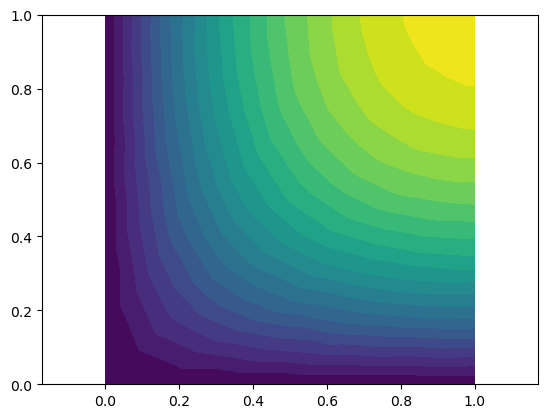

In [33]:
# Square, Dirichlet left/bottom
pv = Float64[0 0; 1 0; 1 1; 0 1; 0 0]
p, t, e = pmesh(pv, 0.15, 0)
e = e[@. (p[e,1] < 1e-6) | (p[e,2] < 1e-6)]

u = fempoi(p, t, e)
tplot(p, t, u)
gcf()

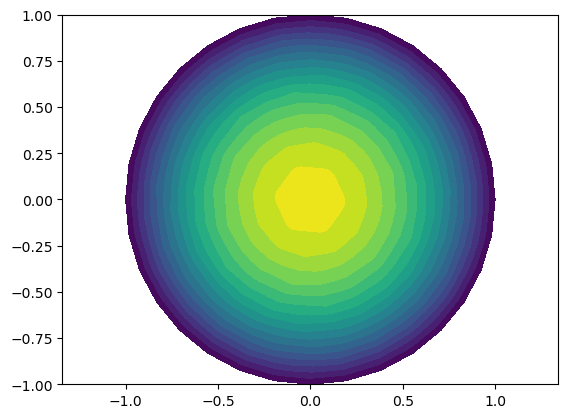

In [34]:
# Circle, all Dirichlet
n = 32; phi = 2pi*(0:n)/n
pv = [cos.(phi)  sin.(phi)]
p, t, e = pmesh(pv, 2pi/n, 0)
u = fempoi(p, t, e)
clf()
tplot(p, t, u)
gcf()

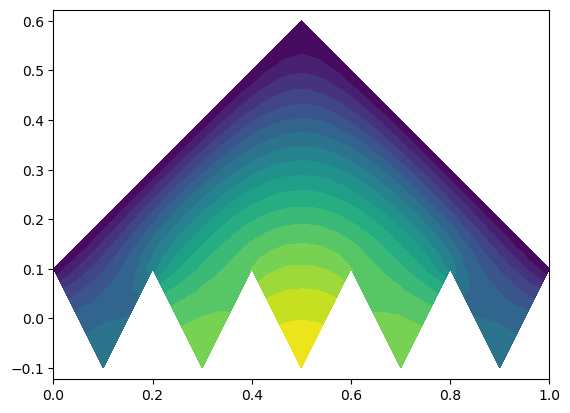

In [35]:
# Generic polygon geometry, mixed Dirichlet/Neumann
x = 0:.1:1
y = 0.1*(-1).^(0:10)
pv = [x y; .5 .6; 0 .1]
p, t, e = pmesh(pv, 0.04, 0)
e = e[@. p[e,2] > (.6 - abs(p[e,1] - 0.5) - 1e-6)]
u = fempoi(p, t, e)
tplot(p, t, u)
gcf()

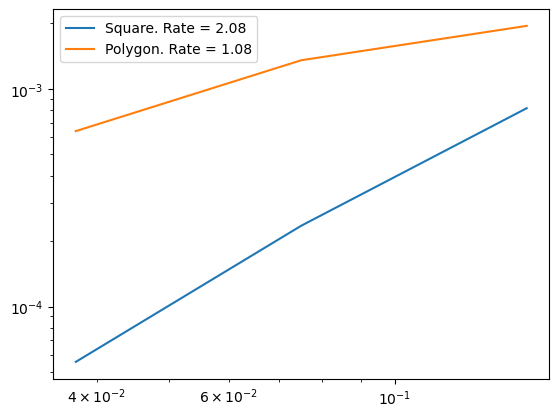

In [36]:
function poiconv(pv, hmax, nrefmax)
    p,t,e = pmesh(pv, hmax, nrefmax)
    u_exact = fempoi(p,t,e)
    errors = []
    for nref = 0:nrefmax-1
        p,t,e = pmesh(pv, hmax, nref)
        u = fempoi(p,t,e)
        push!(errors, maximum(abs.(u - u_exact[1:length(u)])))
    end
    return errors
end

hmax = 0.15
pv_square = Float64[0 0; 1 0; 1 1; 0 1; 0 0]
pv_polygon = Float64[0 0; 1 0; .5 .5; 1 1; 0 1; 0 0]
errors_square = poiconv(pv_square, hmax, 3)
errors_polygon = poiconv(pv_polygon, hmax, 3)
errors = [errors_square errors_polygon]
clf()
rates = @. log2(errors[end-1,:]) - log2(errors[end,:])
loglog(hmax ./ [1,2,4], errors, label=["Square.", "Polygon."] .* " Rate = ".* string.(round.(rates, digits=2)))
legend()
gcf()